In [1]:
import random #randomização
import numpy as np #tratamentos numéricos
import pandas as pd #dataframes
import seaborn as sns #distribuições
from sklearn import tree #arvore de decisão
from sklearn import metrics #metricas
from sklearn.svm import SVC #técnica SVM
from imblearn import combine #técnica de SMOTE (combine)
import matplotlib.pyplot as plt #gráficos
from imblearn import over_sampling #técnica de SMOTE (over_sampling)
from imblearn import under_sampling #técnica de SMOTE (under_sampling)
from sklearn.metrics import f1_score #avaliar modelo pela métrica f1_score
from sklearn.decomposition import PCA #técnica PCA
from sklearn.metrics import recall_score #avaliar modelo pela métrica recall_score
from sklearn.metrics import roc_auc_score #avaliar modelo pela métrica roc_auc_score
from sklearn.naive_bayes import GaussianNB #Naive Bayes
from sklearn.metrics import accuracy_score #avaliar modelo pela métrica accuracy_score
from sklearn.metrics import precision_score #avaliar modelo pela métrica precision_score
from sklearn.preprocessing import StandardScaler #padronização
from sklearn.metrics import plot_confusion_matrix #análise de matriz de confusão
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression #regressão linear
from sklearn.neighbors import KNeighborsClassifier #k-vizinhos
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras #redes neurais com keras
import tensorflow as tf

from numpy.random import seed
from tensorflow.random import set_seed
from sklearn.metrics import classification_report # metricas de validação

# Descrição dos Dados

In [2]:
#df = pd.read_csv('sgemm_product.csv',sep=',')
df1 = pd.read_csv('sgemm_product.csv',sep=',')
df = df1.sample(frac=0.5) #limitar o tamanho apenas para processamento mais rápido e testar técnicas
print('Número de linhas e colunas:',df.shape)
df.head()

Número de linhas e colunas: (120800, 18)


,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
168934,128,32,32,32,16,32,32,2,1,1,0,1,1,0,67.53,67.57,67.46,67.74
122150,64,128,16,32,8,16,16,8,1,4,0,1,1,0,43.32,44.13,42.88,44.27
206951,128,128,16,8,16,16,32,8,4,1,0,1,1,1,894.65,900.16,899.84,900.49
149065,128,16,32,32,8,16,16,2,4,1,1,0,0,1,65.56,65.55,65.56,65.57
156638,128,32,16,16,16,32,32,2,2,1,1,1,1,0,29.28,29.80,29.38,29.32


##### Significado dos dados da base
    - Input:
        MWG, NWG: per-matrix 2D tiling at workgroup level: {16, 32, 64, 128} (integer)
        KWG: inner dimension of 2D tiling at workgroup level: {16, 32} (integer)
        MDIMC, NDIMC: local workgroup size: {8, 16, 32} (integer)
        MDIMA, NDIMB: local memory shape: {8, 16, 32} (integer)
        KWI: kernel loop unrolling factor: {2, 8} (integer)
        VWM, VWN: per-matrix vector widths for loading and storing: {1, 2, 4, 8} (integer)
        STRM, STRN: enable stride for accessing off-chip memory within a single thread: {0, 1} (categorical)
        SA, SB: per-matrix manual caching of the 2D workgroup tile: {0, 1} (categorical)
    
    - Output:
        Run1, Run2, Run3, Run4: performance times in milliseconds for 4 independent runs using the same parameters.
<img src='./img/img-SGEMM-GPU.gif'>

In [3]:
#descrição estatística
df.describe()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
count,120800.000000,120800.000000,120800.000000,120800.000000,120800.000000,120800.000000,120800.000000,120800.000000,120800.000000,120800.000000,120800.000000,120800.000000,120800.000000,120800.000000,120800.000000,120800.000000,120800.000000,120800.000000
mean,80.395762,80.445695,25.536821,13.946887,13.946954,17.365762,17.411854,4.985149,2.450033,2.448758,0.500058,0.499570,0.499081,0.501722,217.214010,217.157530,217.112086,217.103981
std,42.446985,42.492472,7.851031,7.882268,7.879428,9.382007,9.399055,2.999976,1.953491,1.955876,0.500002,0.500002,0.500001,0.499999,368.383951,368.056236,368.032343,368.055322
min,16.000000,16.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.780000,13.760000,13.730000,13.690000
25%,32.000000,32.000000,16.000000,8.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,40.610000,40.660000,40.600000,40.580000
50%,64.000000,64.000000,32.000000,8.000000,8.000000,16.000000,16.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,1.000000,69.730000,69.840000,69.670000,69.750000
75%,128.000000,128.000000,32.000000,16.000000,16.000000,32.000000,32.000000,8.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,227.720000,227.790000,227.792500,227.810000
max,128.000000,128.000000,32.000000,32.000000,32.000000,32.000000,32.000000,8.000000,8.000000,8.000000,1.000000,1.000000,1.000000,1.000000,3324.150000,3337.280000,3359.220000,3342.300000


# Tratamento e transformação dos dados

## Dados duplicados

In [4]:
#verificando se temos duplicidade dos dados
df[df.duplicated() == True]

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)


## Dados faltantes

In [5]:
#verificando se temos dados faltantes
df.isnull().sum()

MWG          0
NWG          0
KWG          0
MDIMC        0
NDIMC        0
MDIMA        0
NDIMB        0
KWI          0
VWM          0
VWN          0
STRM         0
STRN         0
SA           0
SB           0
Run1 (ms)    0
Run2 (ms)    0
Run3 (ms)    0
Run4 (ms)    0
dtype: int64

## Outliers

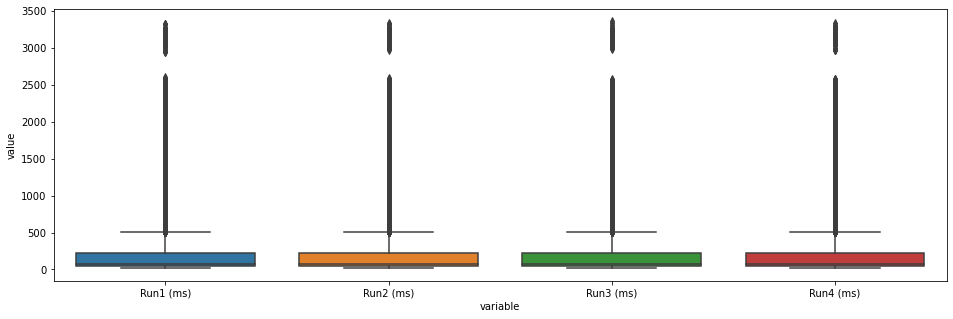

In [6]:
#verificando outliers dos tempos de resposta
plt.figure(figsize=(16,5))
sns.boxplot(x="variable", y="value", data=pd.melt(df.iloc[:,-4:]))
plt.show()

In [7]:
#detectando e removendo outliers
def detect_remove_outlier(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3-Q1
    mask = ((data > (Q1 - 1.5 * IQR)) & (data < (Q3 + 1.5 * IQR)))
    data_clean = data[mask]
    return data_clean

df_clean = detect_remove_outlier(df)
df_clean.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
168934,128,32,32,NaN,16.0,32,32,2,1,1,0,1,1,0,67.53,67.57,67.46,67.74
122150,64,128,16,NaN,8.0,16,16,8,1,4,0,1,1,0,43.32,44.13,42.88,44.27
206951,128,128,16,8.0,16.0,16,32,8,4,1,0,1,1,1,NaN,NaN,NaN,NaN
149065,128,16,32,NaN,8.0,16,16,2,4,1,1,0,0,1,65.56,65.55,65.56,65.57
156638,128,32,16,16.0,16.0,32,32,2,2,1,1,1,1,0,29.28,29.80,29.38,29.32


In [8]:
#verificando dados faltantes obtidos pela função de outlier
df_clean.isnull().sum().sort_values(ascending=False).head(18)

MDIMC        15704
NDIMC        15690
Run4 (ms)    13489
Run3 (ms)    13487
Run2 (ms)    13484
Run1 (ms)    13402
NDIMB            0
NWG              0
KWG              0
MDIMA            0
VWM              0
KWI              0
VWN              0
STRM             0
STRN             0
SA               0
SB               0
MWG              0
dtype: int64

In [9]:
#dropando as linhas com NaN
df_clean = df_clean.dropna()
df_clean = df_clean.reset_index()
print('Tamanho da base sem outliers:',df_clean.shape)
df_clean.isnull().sum().sort_values(ascending=False).head(18)

Tamanho da base sem outliers: (76464, 19)


Run4 (ms)    0
KWI          0
MWG          0
NWG          0
KWG          0
MDIMC        0
NDIMC        0
MDIMA        0
NDIMB        0
VWM          0
Run3 (ms)    0
VWN          0
STRM         0
STRN         0
SA           0
SB           0
Run1 (ms)    0
Run2 (ms)    0
dtype: int64

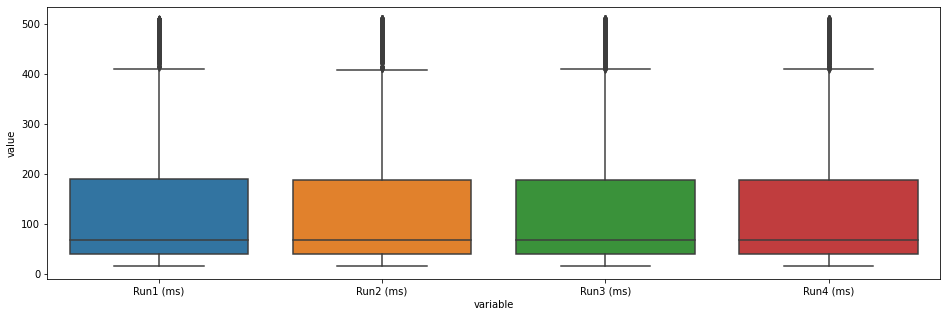

In [10]:
#verificando boxplot dos tempos de resposta após tratamento de outliers
plt.figure(figsize=(16,5))
sns.boxplot(x="variable", y="value", data=pd.melt(df_clean.iloc[:,-4:]))
plt.show()

## Dados correlacionados

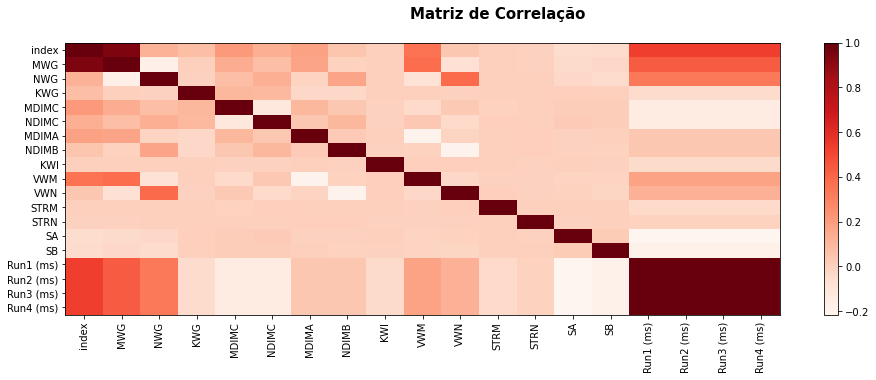

In [11]:
#matriz de correlação
plt.figure(figsize=(16,5))

plt.imshow(df_clean.corr(), cmap='Reds', interpolation='none', aspect='auto')
plt.xticks(range(len(df_clean.corr())), df_clean.corr().columns, rotation='vertical')
plt.yticks(range(len(df_clean.corr())), df_clean.corr().columns)
plt.suptitle('Matriz de Correlação', fontsize=15, fontweight='bold')
plt.grid(False)
plt.colorbar()
plt.show()

## Dados distribuídos e balanceados

In [12]:
#Consolidando os atributos de predição em um único apenas, considerando suas médias
run = df_clean.iloc[:,-4:].mean(axis=1)
df_clean['Run (ms)'] = pd.Series(run)

In [13]:
data = df_clean.copy()
data

,index,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms),Run (ms)
0,156638,128,32,16,16.0,16.0,32,32,2,2,1,1,1,1,0,29.28,29.80,29.38,29.32,29.4450
1,232410,128,128,32,16.0,16.0,8,16,8,1,8,1,0,1,0,135.75,137.27,138.65,138.29,137.4900
2,132689,64,128,32,16.0,8.0,8,16,8,2,8,0,0,0,1,188.30,188.30,188.25,188.29,188.2850
3,21921,32,16,32,16.0,8.0,32,8,8,1,1,0,0,0,1,74.88,74.83,74.86,74.88,74.8625
4,213460,128,128,16,16.0,16.0,16,16,2,4,2,0,1,0,0,323.35,326.52,326.48,326.59,325.7350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76459,89060,64,64,16,8.0,8.0,32,8,8,1,1,0,1,0,0,257.33,257.69,257.35,257.41,257.4450
76460,67198,64,16,16,8.0,16.0,8,8,8,8,1,1,1,1,0,60.56,60.46,60.44,60.57,60.5075
76461,120922,64,128,16,16.0,16.0,16,16,8,1,8,1,0,1,0,24.41,24.37,24.43,24.20,24.3525
76462,158887,128,32,32,8.0,8.0,16,32,2,1,1,0,1,1,1,312.86,317.63,313.49,310.33,313.5775


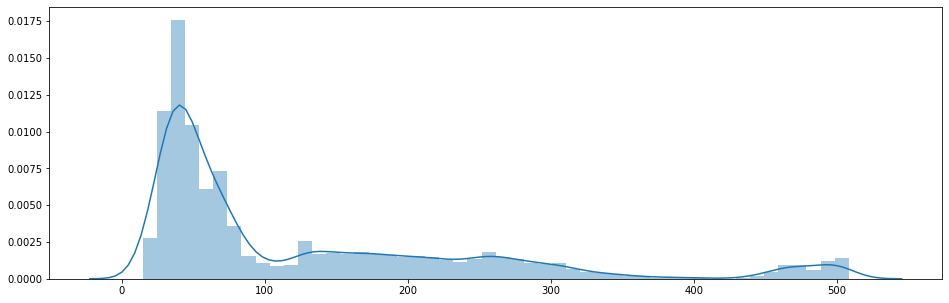

In [14]:
#verificando a distribuição dos dados
plt.figure(figsize=(16,5))
fig = sns.distplot(data.iloc[:,-1:])

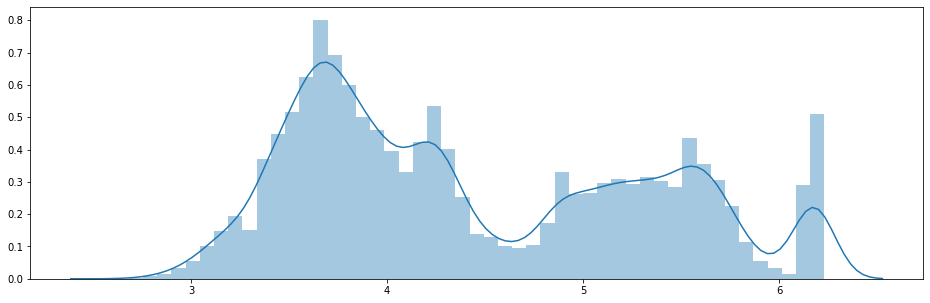

In [15]:
#aplicando log na variável alvo
run_log = np.log(data['Run (ms)'])
data.insert(20,'Run Log (ms)',run_log)

plt.figure(figsize=(16,5))
fig = sns.distplot(data.iloc[:,-1:])

In [16]:
#caso queira apagar a última coluna para dar rollback nos dados
#data.drop(data.iloc[:,-1:],axis = 1, inplace = True)
data

,index,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,...,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms),Run (ms),Run Log (ms)
0,156638,128,32,16,16.0,16.0,32,32,2,2,...,1,1,1,0,29.28,29.80,29.38,29.32,29.4450,3.382524
1,232410,128,128,32,16.0,16.0,8,16,8,1,...,1,0,1,0,135.75,137.27,138.65,138.29,137.4900,4.923551
2,132689,64,128,32,16.0,8.0,8,16,8,2,...,0,0,0,1,188.30,188.30,188.25,188.29,188.2850,5.237957
3,21921,32,16,32,16.0,8.0,32,8,8,1,...,0,0,0,1,74.88,74.83,74.86,74.88,74.8625,4.315653
4,213460,128,128,16,16.0,16.0,16,16,2,4,...,0,1,0,0,323.35,326.52,326.48,326.59,325.7350,5.786084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76459,89060,64,64,16,8.0,8.0,32,8,8,1,...,0,1,0,0,257.33,257.69,257.35,257.41,257.4450,5.550806
76460,67198,64,16,16,8.0,16.0,8,8,8,8,...,1,1,1,0,60.56,60.46,60.44,60.57,60.5075,4.102767
76461,120922,64,128,16,16.0,16.0,16,16,8,1,...,1,0,1,0,24.41,24.37,24.43,24.20,24.3525,3.192635
76462,158887,128,32,32,8.0,8.0,16,32,2,1,...,0,1,1,1,312.86,317.63,313.49,310.33,313.5775,5.748047


In [17]:
#aplicando discretização dos dados no tempo de resposta

#classificação utilizando os dados reais
#threshold = [0,100,200,300,400,500,600]
threshold = [0,20,40,60,80,100,200,300,400,500,600]
run_disc = pd.cut(data['Run (ms)'], bins=threshold)

#classificação utilizando dados log
#threshold = [3,4,5,6] #classificação utilizando os dados log
#run_disc = pd.cut(data['Run Log (ms)'], bins=threshold)

#inserindo na base
data.insert(21,'Run Discretizado (ms)',run_disc)

#realizando o mapping numbers (transformando categorias em números)
data['Run Discretizado Mapping (ms)'] = data['Run Discretizado (ms)'].astype('category').cat.codes
data['Run Discretizado Mapping (ms)'].unique()

array([1, 5, 3, 7, 6, 2, 8, 0, 4, 9], dtype=int8)

In [18]:
#problema de classificação binária (maior ou menor que a média)

#classificação utilizando os dados reais
avg = data['Run (ms)'].mean()
data.loc[data['Run (ms)'] <= avg, 'Run Bin'] = 0
data.loc[data['Run (ms)'] >  avg, 'Run Bin'] = 1

#classificação utilizando os dados log
#avg = data['Run Log (ms)'].mean()
#data.loc[data['Run Log (ms)'] <= avg, 'Run Bin'] = 0
#data.loc[data['Run Log (ms)'] >  avg, 'Run Bin'] = 1

#obtendo dados
run_bin = data[['Run Bin']].values.astype('int')
data.drop(data.iloc[:,-1:],axis = 1, inplace = True)

#inserindo na base de dados
data.insert(23,'Run Binario',run_bin)

print('Se menor ou igual que ',avg,'então será 0')
print('Se maior que ',avg,'então será 1')

data

Se menor ou igual que  128.05195036226098 então será 0
Se maior que  128.05195036226098 então será 1


,index,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,...,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms),Run (ms),Run Log (ms),Run Discretizado (ms),Run Discretizado Mapping (ms),Run Binario
0,156638,128,32,16,16.0,16.0,32,32,2,2,...,0,29.28,29.80,29.38,29.32,29.4450,3.382524,"(20, 40]",1,0
1,232410,128,128,32,16.0,16.0,8,16,8,1,...,0,135.75,137.27,138.65,138.29,137.4900,4.923551,"(100, 200]",5,1
2,132689,64,128,32,16.0,8.0,8,16,8,2,...,1,188.30,188.30,188.25,188.29,188.2850,5.237957,"(100, 200]",5,1
3,21921,32,16,32,16.0,8.0,32,8,8,1,...,1,74.88,74.83,74.86,74.88,74.8625,4.315653,"(60, 80]",3,0
4,213460,128,128,16,16.0,16.0,16,16,2,4,...,0,323.35,326.52,326.48,326.59,325.7350,5.786084,"(300, 400]",7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76459,89060,64,64,16,8.0,8.0,32,8,8,1,...,0,257.33,257.69,257.35,257.41,257.4450,5.550806,"(200, 300]",6,1
76460,67198,64,16,16,8.0,16.0,8,8,8,8,...,0,60.56,60.46,60.44,60.57,60.5075,4.102767,"(60, 80]",3,0
76461,120922,64,128,16,16.0,16.0,16,16,8,1,...,0,24.41,24.37,24.43,24.20,24.3525,3.192635,"(20, 40]",1,0
76462,158887,128,32,32,8.0,8.0,16,32,2,1,...,1,312.86,317.63,313.49,310.33,313.5775,5.748047,"(300, 400]",7,1


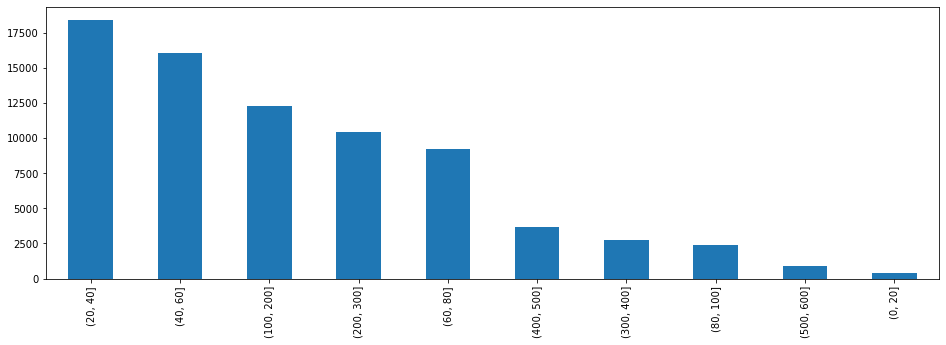

In [19]:
#verificando balanceamento entre as variáveis categóricas (multiclasse)
fig = plt.figure(figsize=(16,5))
fig = data['Run Discretizado (ms)'].value_counts().plot(kind='bar')

Distribuição das classes:
[000,020]: 0.51 %
[020,040]: 24.08 %
[040,060]: 20.99 %
[060,080]: 12.01 %
[000,100]: 3.15 %
[100,200]: 16.01 %
[200,300]: 13.66 %
[300,400]: 3.60  %
[400,500]: 4.80  %
[500,600]: 1.19  %


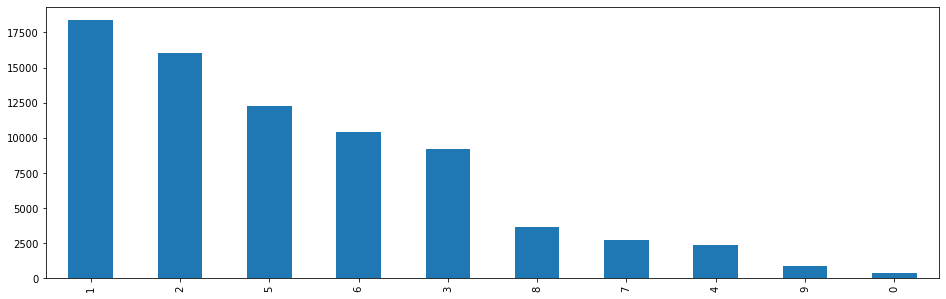

In [20]:
#verificando balanceamento entre as variáveis categóricas mapping (multiclasse)
fig = plt.figure(figsize=(16,5))
fig = data['Run Discretizado Mapping (ms)'].value_counts().plot(kind='bar')

#classificação utilizando os dados reais
mask0 = (data['Run Discretizado Mapping (ms)'] == 0)
mask1 = (data['Run Discretizado Mapping (ms)'] == 1)
mask2 = (data['Run Discretizado Mapping (ms)'] == 2)
mask3 = (data['Run Discretizado Mapping (ms)'] == 3)
mask4 = (data['Run Discretizado Mapping (ms)'] == 4)
mask5 = (data['Run Discretizado Mapping (ms)'] == 5)
mask6 = (data['Run Discretizado Mapping (ms)'] == 6)
mask7 = (data['Run Discretizado Mapping (ms)'] == 7)
mask8 = (data['Run Discretizado Mapping (ms)'] == 8)
mask9 = (data['Run Discretizado Mapping (ms)'] == 9)

print('Distribuição das classes:')
print("[000,020]: %.2f" % (len(data[mask0].index.values)/len(data['Run Discretizado Mapping (ms)']) * 100),'%')
print("[020,040]: %.2f" % (len(data[mask1].index.values)/len(data['Run Discretizado Mapping (ms)']) * 100),'%')
print("[040,060]: %.2f" % (len(data[mask2].index.values)/len(data['Run Discretizado Mapping (ms)']) * 100),'%')
print("[060,080]: %.2f" % (len(data[mask3].index.values)/len(data['Run Discretizado Mapping (ms)']) * 100),'%')
print("[000,100]: %.2f" % (len(data[mask4].index.values)/len(data['Run Discretizado Mapping (ms)']) * 100),'%')
print("[100,200]: %.2f" % (len(data[mask5].index.values)/len(data['Run Discretizado Mapping (ms)']) * 100),'%')
print("[200,300]: %.2f" % (len(data[mask6].index.values)/len(data['Run Discretizado Mapping (ms)']) * 100),'%')
print("[300,400]: %.2f" % (len(data[mask7].index.values)/len(data['Run Discretizado Mapping (ms)']) * 100),' %')
print("[400,500]: %.2f" % (len(data[mask8].index.values)/len(data['Run Discretizado Mapping (ms)']) * 100),' %')
print("[500,600]: %.2f" % (len(data[mask9].index.values)/len(data['Run Discretizado Mapping (ms)']) * 100),' %')

Distribuição das classes:
 <= Média: 63.64 %
 >  Média: 36.36 %


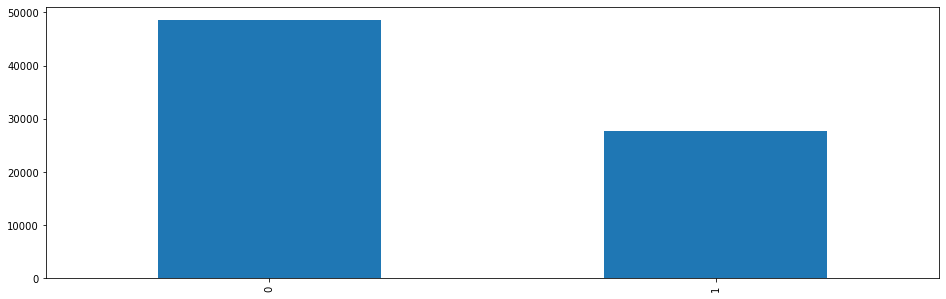

In [21]:
#verificando balanceamento entre as variáveis binárias
fig = plt.figure(figsize=(16,5))
fig = data['Run Binario'].value_counts().plot(kind='bar')

mask0 = (data['Run Binario'] == 0)
mask1 = (data['Run Binario'] == 1)

print('Distribuição das classes:')
print(" <= Média: %.2f" % (len(data[mask0].index.values)/len(data['Run Binario']) * 100),'%')
print(" >  Média: %.2f" % (len(data[mask1].index.values)/len(data['Run Binario']) * 100),'%')

In [22]:
#separando os dados em conjunto de treinamento e testes, na proporção 80-20
perc = 0.8

#salvando y como seria valores reais em logaritimo
x_train_log, y_train_log = data.iloc[0:int(len(data)*perc),1:-9],data['Run Log (ms)'].iloc[0:int(len(data)*perc)]
x_test_log, y_test_log = data.iloc[int(len(data)*perc):int(len(data)),1:-9],data['Run Log (ms)'].iloc[int(len(data)*perc):int(len(data))]

#salvando y como serie classificação multiclasse
x_train_m, y_train_m = data.iloc[0:int(len(data)*perc),1:-9],data['Run Discretizado (ms)'].iloc[0:int(len(data)*perc)]
x_test_m, y_test_m = data.iloc[int(len(data)*perc):int(len(data)),1:-9],data['Run Discretizado (ms)'].iloc[int(len(data)*perc):int(len(data))]

#salvando y como serie classificação multiclasse mapping number
x_train_map, y_train_map = data.iloc[0:int(len(data)*perc),1:-9],data['Run Discretizado Mapping (ms)'].iloc[0:int(len(data)*perc)]
x_test_map, y_test_map = data.iloc[int(len(data)*perc):int(len(data)),1:-9],data['Run Discretizado Mapping (ms)'].iloc[int(len(data)*perc):int(len(data))]

#salvando y como classificação binário
x_train_b, y_train_b = data.iloc[0:int(len(data)*perc),1:-9],data['Run Binario'].iloc[0:int(len(data)*perc)]
x_test_b, y_test_b = data.iloc[int(len(data)*perc):int(len(data)),1:-9],data['Run Binario'].iloc[int(len(data)*perc):int(len(data))]


sc = StandardScaler()
x_train_m = sc.fit_transform(x_train_m)
x_test_m = sc.fit_transform(x_test_m)

x_train_map = sc.fit_transform(x_train_map)
x_test_map = sc.fit_transform(x_test_map)

x_train_b = sc.fit_transform(x_train_b)
x_test_b = sc.fit_transform(x_test_b)

print('Tamanho da amostra de treinamento:',len(x_train_b))
print('Tamanho da amostra de teste:',len(x_test_b))

Tamanho da amostra de treinamento: 61171
Tamanho da amostra de teste: 15293


### MODELAGEM

In [ ]:
#treinando um classificador
clf = SVC(gamma='auto')
clf.fit(x_train_map,y_train_map)
ZY_ = clf.predict(x_test_map)


disp = plot_confusion_matrix(clf,x_test_map,y_test_map,cmap=plt.cm.Blues,normalize='true')

In [ ]:
print(disp)

In [ ]:
print('+--------------Classificador--------------+')
print('| Accuracy: ', '%.2f' % accuracy_score(y_test_map,ZY_),'                        |')
print('| Balanced Accuracy: ', '%.2f' % metrics.balanced_accuracy_score(ZY_, y_test_map),'               |')
print('| F1 score: ', '%.2f' % f1_score(y_test_map, ZY_, average='weighted', labels=np.unique(ZY_)),'                        |')
print('| Precision:', '%.2f' % precision_score(y_test_map, ZY_, average='weighted', labels=np.unique(ZY_)),'                        |')
print('| Recall:   ', '%.2f' % recall_score(y_test_map, ZY_, average='weighted', labels=np.unique(ZY_)),'                        |')
print('+-----------------------------------------+')

#You'll have precision, recall, f1-score and support for each class you're trying to find.
###The recall means "how many of this class you find over the whole number of element of this class"
###The precision will be "how many are correctly classified among that class"
###The f1-score is the harmonic mean between precision & recall
###The support is the number of occurence of the given class in your dataset (so you have 37.5K of class 0 and 37.5K of class 1, which is a really well balanced dataset.

###The thing is, precision and recall is highly used for imbalanced dataset because in an highly imbalanced dataset, a 99% accuracy can be meaningless.
###I would say that you don't really need to look at these metrics for this problem , unless a given class should absolutely be correctly determined.
###To answer your other question, you cannot compare the precision and the recall over two classes. This only means you're classifier is better to find class 0 over class 1.
###Precision and recall of sklearn.metrics.precision_score or recall_score should not be different. But as long as the code is not provided, this is impossible to determine the root cause of this.

###ANALOGIA PRECISION E RECALL
#Imaginando, navegamos sobre o mar e lançamos nossa rede.
#Se a movimentação de peixes for enorme, enquanto a rede for bem pequena -> Veremos peixes em posições muito altas na rede, significa que a precisão é alta. Mas nós só temos uma minoria da movimentação, significa que o recall é baixo.
#Enquanto isso, há apenas um pequeno grupo de peixes, mas temos uma rede enorme -> Veremos que apenas uma pequena parte da rede tem peixes, o que significa que a precisão está baixa. Mas, felizmente, pegamos todos os peixes na corrida, o que significa que o recall está alto.
#F1-score é uma média entre o precision e o recall


from sklearn.metrics import classification_report # metricas de validação
print('+------------------------------------------------------------------+')
print(classification_report(y_test_map, ZY_))
print('+------------------------------------------------------------------+')

In [ ]:
#aplicando técnicas de SMOTE para verificar uma estratégia melhor de balanceamento para validar os modelos

#Over Sampling
oversamp = over_sampling.SMOTE() # sampling_strategy pode ser usado para casos binários
Xo, Yo = oversamp.fit_resample(x_train_map, y_train_map)

plt.figure(figsize=(16,5))
h = plt.hist(Yo)

In [ ]:
#Under Sampling
undersamp = under_sampling.RandomUnderSampler()
Xu, Yu = undersamp.fit_resample(x_train_map, y_train_map)

plt.figure(figsize=(16,5))
h = plt.hist(Yu)

In [ ]:
#Over Under Sampling (estratégia mista)
overunder = combine.SMOTEENN(sampling_strategy='all')
Xc, Yc = overunder.fit_resample(x_train_map, y_train_map)

plt.figure(figsize=(16,5))
h = plt.hist(Yc)

In [ ]:
#avaliando qual a melhor estratégia de SMOTE

#treinando um classificador com o balanceamento original
clf = SVC(gamma='auto')
clf.fit(x_train_map,y_train_map)
ZY_ = clf.predict(x_test_map)

#treinando um classificador com o balanceamento Over Sampling
clf_ov = SVC(gamma='auto')
clf_ov.fit(Xo,Yo)
ZYov_ = clf_ov.predict(x_test_map)

#treinando um classificador com o balanceamento Under Sampling
clf_un = SVC(gamma='auto')
clf_un.fit(Xu,Yu)
ZYun_ = clf_un.predict(x_test_map)

#treinando um classificador com o balanceamento Over Under Sampling
clf_co = SVC(gamma='auto')
clf_co.fit(Xc,Yc)
ZYco_ = clf_co.predict(x_test_map)

In [ ]:
accb_base = metrics.balanced_accuracy_score(y_test_map, ZY_)
accb_ov = metrics.balanced_accuracy_score(y_test_map, ZYov_)
accb_un = metrics.balanced_accuracy_score(y_test_map, ZYun_)
accb_co = metrics.balanced_accuracy_score(y_test_map, ZYco_)
print("Acurácia balanceada base: %0.3f" % (accb_base))
print("Acurácia balanceada oversampling: %0.3f" % (accb_ov))
print("Acurácia balanceada undersampling: %0.3f" % (accb_un))
print("Acurácia balanceada combinado: %0.3f" % (accb_co))

In [ ]:
disp = plot_confusion_matrix(clf, x_test_map, y_test_map,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

In [ ]:
disp = plot_confusion_matrix(clf_ov, x_test_map, y_test_map,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

In [ ]:
disp = plot_confusion_matrix(clf_un, x_test_map, y_test_map,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

In [ ]:
disp = plot_confusion_matrix(clf_co, x_test_map, y_test_map,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

In [ ]:
#Linear SVM - notebook Kaggle
#print('Linear Model',end='\n')
#lsvclassifier = SVC(kernel='linear')
#lsvclassifier.fit(x_train_b, y_train_b)

#Applying k-Fold Cross Validation
#accuracies = cross_val_score(estimator = lsvclassifier, X = x_train_b, y = y_train_b, cv = 5)
#mean_svm_linear=accuracies.mean()
#std_svm_linear=accuracies.std()

#After using 5 fold cross validation
#print('After 5 fold cross validation:')
#print('Mean of Accuracies: ',mean_svm_linear*100,end='\n')
#print('Standard deviation of Accuracies',std_svm_linear*100,end='\n')

#Predict SVM
#y_predl = lsvclassifier.predict(x_test_b)

#Confusion Matrix
#print('Test Output:')
#print('Confusion Matrix:')
#print(sk.confusion_matrix(y_test_b,y_predl))
#print('Classification Report:')
#print(sk.classification_report(y_test_b,y_predl))
#print('Accuracy: ',sk.accuracy_score(y_test_b, y_predl, normalize=True, sample_weight=None))

In [ ]:
#aplicando PCA e plotando dados com conjunto original de dados de treino (multiclasse)
pca = PCA(n_components=10, random_state=1)
pca_result = pca.fit_transform(x_train_m)

#realizando o plot
fig = plt.figure(figsize=(20,6))
sns.scatterplot(x=pca_result[:,0],y=pca_result[:,1],alpha='auto', hue=y_train_m, palette='tab10')
plt.title('Scatterplot com projeção PCA do conjunto de dados multiclasse')
plt.show()

In [ ]:
#aplicando PCA e plotando dados com conjunto original de dados de treino (multiclasse mapping number)
pca = PCA(n_components=10, random_state=1)
pca_result = pca.fit_transform(x_train_map)

#realizando o plot
fig = plt.figure(figsize=(20,6))
sns.scatterplot(x=pca_result[:,0],y=pca_result[:,1],alpha='auto', hue=y_train_map, palette='tab10')
plt.title('Scatterplot com projeção PCA do conjunto de dados multiclasse mapping number')
plt.show()

In [ ]:
#aplicando PCA e plotando dados com conjunto original de dados de treino (binário)
pca = PCA(n_components=2, random_state=1)
pca_result = pca.fit_transform(x_train_b)

#realizando o plot
fig = plt.figure(figsize=(20,6))
sns.scatterplot(x=pca_result[:,0],y=pca_result[:,1],alpha='auto', hue=y_train_b, palette='prism')
plt.title('Scatterplot com projeção PCA do conjunto de dados binário')
plt.show()

In [ ]:
#01.K-vizinhos com classificação binária

cv_knn = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

train_x = x_train_b[:10000]
train_y = y_train_b[:10000]

mauc_knn = []
macc_knn = []
vk = []
for k in range(1, 21):
    vauc_knn = []
    vacc_knn = []
    for train_index, test_index in cv_knn.split(train_x, train_y):
        x_train, x_test = x_train_b[train_index], x_train_b[test_index]
        y_train, y_test = y_train_b[train_index], y_train_b[test_index]
        model_knn = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
        model_knn.fit(x_train,y_train)
        y_pred_knn = model_knn.predict(x_test) 
        score = accuracy_score(y_pred_knn, y_test)
        vauc_knn.append(roc_auc_score(y_test, y_pred_knn))
        vacc_knn.append(accuracy_score(y_pred_knn, y_test))
    macc_knn.append(np.mean(vacc_knn))
    mauc_knn.append(np.mean(vauc_knn))
    vk.append(k)
    
best_k = np.argmax(mauc_knn)+1
print('Melhor k:', best_k, ' AUC:',mauc_knn[best_k-1])
plt.figure(figsize=(10,5))
plt.plot(vk, mauc_knn, '-ro', label= 'AUC')
plt.plot(vk, macc_knn, '-bo', label = 'Accuracy')
plt.xlabel('k', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
#K-vizinhos, aplicando o modelo com o melhor k

model_KNN = KNeighborsClassifier(n_neighbors = 15, metric='euclidean')
model_KNN.fit(x_train_b,y_train_b)
y_pred_KNN = model_KNN.predict(x_test_b)
score_KNN = accuracy_score(y_pred_KNN, y_test_b)

print('+--------------Kvizinhos--------------+')
print('| Accuracy: ', '%.2f' % accuracy_score(y_pred_KNN, y_test_b),'                    |')
print('| Balanced Accuracy: ', '%.2f' % metrics.balanced_accuracy_score(y_pred_KNN, y_test_b),'           |')
print('| F1 score: ', '%.2f' % f1_score(y_test_b, y_pred_KNN, average='weighted', labels=np.unique(y_pred_KNN)),'                    |')
print('| Precision:', '%.2f' % precision_score(y_test_b, y_pred_KNN, average='weighted', labels=np.unique(y_pred_KNN)),'                    |')
print('| Recall:   ', '%.2f' % recall_score(y_test_b, y_pred_KNN, average='weighted', labels=np.unique(y_pred_KNN)),'                    |')
print('+-------------------------------------+')

In [ ]:
#K-vizinhos, aplicando o modelo com o melhor k para multiclasse com mapping number

model_KNN = KNeighborsClassifier(n_neighbors = 15, metric='euclidean')
model_KNN.fit(x_train_map,y_train_map)
y_pred_KNN = model_KNN.predict(x_test_map)
score_KNN = accuracy_score(y_pred_KNN, y_test_map)

#print('+--------------Kvizinhos--------------+')
#print('| Accuracy: ', '%.2f' % accuracy_score(y_pred_KNN, y_test_map),'                    |')
#print('| Balanced Accuracy: ', '%.2f' % metrics.balanced_accuracy_score(y_pred_KNN, y_test_map),'           |')
#print('| F1 score: ', '%.2f' % f1_score(y_test_map, y_pred_KNN, average='weighted', labels=np.unique(y_pred_KNN)),'                    |')
#print('| Precision:', '%.2f' % precision_score(y_test_map, y_pred_KNN, average='weighted', labels=np.unique(y_pred_KNN)),'                    |')
#print('| Recall:   ', '%.2f' % recall_score(y_test_map, y_pred_KNN, average='weighted', labels=np.unique(y_pred_KNN)),'                    |')
#print('+-------------------------------------+')


print('+------------------------------------------------------------------+')
print(classification_report(y_test_map, y_pred_KNN))
print('+------------------------------------------------------------------+')

In [ ]:
#K-vizinhos, aplicando o modelo com o melhor k para multiclasse com mapping number, com dados SMOTE Over Sampling

model_KNN = KNeighborsClassifier(n_neighbors = 15, metric='euclidean')
model_KNN.fit(Xo,Yo)
y_pred_KNN = model_KNN.predict(x_test_map)
score_KNN = accuracy_score(y_pred_KNN, y_test_map)

print('+--------------Kvizinhos--------------+')
print('| Accuracy: ', '%.2f' % accuracy_score(y_pred_KNN, y_test_map),'                    |')
print('| Balanced Accuracy: ', '%.2f' % metrics.balanced_accuracy_score(y_pred_KNN, y_test_map),'           |')
print('| F1 score: ', '%.2f' % f1_score(y_test_map, y_pred_KNN, average='weighted', labels=np.unique(y_pred_KNN)),'                    |')
print('| Precision:', '%.2f' % precision_score(y_test_map, y_pred_KNN, average='weighted', labels=np.unique(y_pred_KNN)),'                    |')
print('| Recall:   ', '%.2f' % recall_score(y_test_map, y_pred_KNN, average='weighted', labels=np.unique(y_pred_KNN)),'                    |')
print('+-------------------------------------+')

In [ ]:
cv_svm = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

train_x = x_train_b[:10000] #pegando apenas uma parte dos dados para viabilizar a execução
train_y = y_train_b[:10000] #pegando apenas uma parte dos dados para viabilizar a execução

mauc_svm = []
macc_svm = []
vc = []

for c in range(1, 21):
    vauc_svm = []
    vacc_svm = []
    for train_index, test_index in cv_svm.split(train_x, train_y):
        x_train, x_test = x_train_b[train_index], x_train_b[test_index]
        y_train, y_test = y_train_b[train_index], y_train_b[test_index]
        model_svm = SVC(C = c, gamma = 'auto')
        model_svm.fit(x_train,y_train)
        y_pred_svm = model_svm.predict(x_test) 
        score = accuracy_score(y_pred_svm, y_test)
        vauc_svm.append(roc_auc_score(y_test, y_pred_svm))
        vacc_svm.append(accuracy_score(y_pred_svm, y_test))
    macc_svm.append(np.mean(vacc_svm))
    mauc_svm.append(np.mean(vauc_svm))
    vc.append(c)

best_c = np.argmax(mauc_svm)+1
print('Melhor c:', best_c, ' AUC:',mauc_svm[best_c-1])
plt.figure(figsize=(10,5))
plt.plot(vc, mauc_svm, '-ro', label= 'AUC')
plt.plot(vc, macc_svm, '-bo', label = 'Accuracy')
plt.xlabel('c', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.legend()
plt.show()

In [ ]:
#aplicando SVM

model_SVM = SVC(kernel='linear', C = 6, 
            random_state=1)

#model_SVM.fit(x_train_map,y_train_map)
model_SVM.fit(Xo,Yo)

y_pred_SVM = model_SVM.predict(x_test_map)

score_SVM = accuracy_score(y_pred_SVM, y_test_map)

print('+-----------------SVM-----------------+')
print('| Accuracy: ', '%.2f' % accuracy_score(y_pred_SVM, y_test_map),'                    |')
print('| Balanced Accuracy: ', '%.2f' % metrics.balanced_accuracy_score(y_pred_SVM, y_test_map),'           |')
print('| F1 score: ', '%.2f' % f1_score(y_test_map, y_pred_SVM, average='weighted', labels=np.unique(y_pred_SVM)),'                    |')
print('| Precision:', '%.2f' % precision_score(y_test_map, y_pred_SVM, average='weighted', labels=np.unique(y_pred_SVM)),'                    |')
print('| Recall:   ', '%.2f' % recall_score(y_test_map, y_pred_SVM, average='weighted', labels=np.unique(y_pred_SVM)),'                    |')
print('+-------------------------------------+')

In [ ]:
model_SVM = SVC(kernel='rbf', C = 6, 
            random_state=1)


model_SVM.fit(x_train_map,y_train_map)
#model_SVM.fit(Xo,Yo)

y_pred_SVM = model_SVM.predict(x_test_map)

score_SVM = accuracy_score(y_pred_SVM, y_test_map)

#print('+-----------------SVM-----------------+')
#print('| Accuracy: ', '%.2f' % accuracy_score(y_pred_SVM, y_test_map),'                    |')
#print('| Balanced Accuracy: ', '%.2f' % metrics.balanced_accuracy_score(y_pred_SVM, y_test_map),'           |')
#print('| F1 score: ', '%.2f' % f1_score(y_test_map, y_pred_SVM, average='weighted', labels=np.unique(y_pred_SVM)),'                    |')
#print('| Precision:', '%.2f' % precision_score(y_test_map, y_pred_SVM, average='weighted', labels=np.unique(y_pred_SVM)),'                    |')
#print('| Recall:   ', '%.2f' % recall_score(y_test_map, y_pred_SVM, average='weighted', labels=np.unique(y_pred_SVM)),'                    |')
#print('+-------------------------------------+')

print('+------------------------------------------------------------------+')
print(classification_report(y_test_map, y_pred_SVM))
print('+------------------------------------------------------------------+')

In [ ]:
#aplicando SVM

#com ponderação (pegando como base a distribuição de classes encontradas anteriormente):
peso_0 = 0.4
peso_1 = 0.6
class_weight = {0: peso_0, 1: peso_1}

model_SVM = SVC(kernel='linear', C = 6, 
            random_state=1,
            class_weight = class_weight)

model_SVM.fit(x_train_b,y_train_b)
y_pred_SVM = model_SVM.predict(x_test_b)

score_SVM = accuracy_score(y_pred_SVM, y_test_b)

print('+-----------------SVM-----------------+')
print('| Accuracy: ', '%.2f' % accuracy_score(y_pred_SVM, y_test_b),'                    |')
print('| Balanced Accuracy: ', '%.2f' % metrics.balanced_accuracy_score(y_pred_SVM, y_test_b),'           |')
print('| F1 score: ', '%.2f' % f1_score(y_test_b, y_pred_SVM, average='weighted', labels=np.unique(y_pred_SVM)),'                    |')
print('| Precision:', '%.2f' % precision_score(y_test_b, y_pred_SVM, average='weighted', labels=np.unique(y_pred_SVM)),'                    |')
print('| Recall:   ', '%.2f' % recall_score(y_test_b, y_pred_SVM, average='weighted', labels=np.unique(y_pred_SVM)),'                    |')
print('+-------------------------------------+')

In [ ]:
#aplicando SVM

#com ponderação (pegando como base a distribuição de classes encontradas anteriormente):
peso_0 = 0.4
peso_1 = 0.6
class_weight = {0: peso_0, 1: peso_1}

model_SVM = SVC(kernel='rbf', C = 6, 
            random_state=1,
            class_weight = class_weight)

model_SVM.fit(x_train_b,y_train_b)
y_pred_SVM = model_SVM.predict(x_test_b)

score_SVM = accuracy_score(y_pred_SVM, y_test_b)

print('+-----------------SVM-----------------+')
print('| Accuracy: ', '%.2f' % accuracy_score(y_pred_SVM, y_test_b),'                    |')
print('| Balanced Accuracy: ', '%.2f' % metrics.balanced_accuracy_score(y_pred_SVM, y_test_b),'           |')
print('| F1 score: ', '%.2f' % f1_score(y_test_b, y_pred_SVM, average='weighted', labels=np.unique(y_pred_SVM)),'                    |')
print('| Precision:', '%.2f' % precision_score(y_test_b, y_pred_SVM, average='weighted', labels=np.unique(y_pred_SVM)),'                    |')
print('| Recall:   ', '%.2f' % recall_score(y_test_b, y_pred_SVM, average='weighted', labels=np.unique(y_pred_SVM)),'                    |')
print('+-------------------------------------+')

In [ ]:
#arvore de decisão critério entropy

model_DTC = tree.DecisionTreeClassifier(criterion = 'entropy', random_state=42)

model_DTC.fit(x_train_map,y_train_map)
#model_DTC.fit(Xo,Yo)

y_pred_DTC = model_DTC.predict(x_test_map) 

#print('--------------Árvore de decisão--------------')
#print('Accuracy:', '%.2f' % accuracy_score(y_test_map, y_pred_DTC))
#print('| Balanced Accuracy: ', '%.2f' % metrics.balanced_accuracy_score(y_test_map, y_pred_DTC),'           |')
#print('F1 score:', '%.2f' % f1_score(y_test_map, y_pred_DTC, average="macro"))
#print('Precision:', '%.2f' % precision_score(y_test_map, y_pred_DTC, average="macro"))
#print('Recall:', '%.2f' % recall_score(y_test_map, y_pred_DTC, average="macro"))


print('+------------------------------------------------------------------+')
print(classification_report(y_test_map, y_pred_DTC))
print('+------------------------------------------------------------------+')

In [ ]:
#arvore de decisão critério gini

model_DTC = tree.DecisionTreeClassifier(criterion = 'gini', random_state=42)

#model_DTC.fit(x_train_map,y_train_map)
model_DTC.fit(Xo,Yo)

y_pred_DTC = model_DTC.predict(x_test_map) 

print('--------------Árvore de decisão--------------')
print('Accuracy:', '%.2f' % accuracy_score(y_test_map, y_pred_DTC))
print('| Balanced Accuracy: ', '%.2f' % metrics.balanced_accuracy_score(y_test_map, y_pred_DTC),'           |')
print('F1 score:', '%.2f' % f1_score(y_test_map, y_pred_DTC, average="macro"))
print('Precision:', '%.2f' % precision_score(y_test_map, y_pred_DTC, average="macro"))
print('Recall:', '%.2f' % recall_score(y_test_map, y_pred_DTC, average="macro"))

In [ ]:
#tree.plot_tree(model_DTC) 

In [ ]:
# 03.Naive Bayes

model_NBC = GaussianNB()
model_NBC.fit(x_train_map,y_train_map)
y_pred_NBC = model_NBC.predict(x_test_map)

#print('--------------Naive Bayes--------------')
#print('Accuracy:', '%.2f' % accuracy_score(y_pred_NBC,y_test_map))
#print('| Balanced Accuracy: ', '%.2f' % metrics.balanced_accuracy_score(y_pred_NBC,y_test_map),'           |')
#print('F1 score:', '%.2f' % f1_score(y_pred_NBC,y_test_map, average="macro"))
#print('Precision:', '%.2f' % precision_score(y_pred_NBC,y_test_map, average="macro"))
#print('Recall:', '%.2f' % recall_score(y_pred_NBC,y_test_map, average="macro"))

print('+------------------------------------------------------------------+')
print(classification_report(y_test_map, y_pred_NBC))
print('+------------------------------------------------------------------+')

In [ ]:
# 03.Naive Bayes

model_NBC = GaussianNB()
model_NBC.fit(x_train_b,y_train_b)
y_pred_NBC = model_NBC.predict(x_test_b)

print('--------------Naive Bayes--------------')
print('Accuracy:', '%.2f' % accuracy_score(y_pred_NBC,y_test_b))
print('| Balanced Accuracy: ', '%.2f' % metrics.balanced_accuracy_score(y_pred_NBC,y_test_b),'           |')
print('F1 score:', '%.2f' % f1_score(y_pred_NBC,y_test_b, average="macro"))
print('Precision:', '%.2f' % precision_score(y_pred_NBC,y_test_b, average="macro"))
print('Recall:', '%.2f' % recall_score(y_pred_NBC,y_test_b, average="macro"))

In [ ]:
# 03.Naive Bayes

model_NBC = GaussianNB()
model_NBC.fit(Xo,Yo)
y_pred_NBC = model_NBC.predict(x_test_map)

print('--------------Naive Bayes--------------')
print('Accuracy:', '%.2f' % accuracy_score(y_pred_NBC,y_test_map))
print('| Balanced Accuracy: ', '%.2f' % metrics.balanced_accuracy_score(y_pred_NBC,y_test_map),'           |')
print('F1 score:', '%.2f' % f1_score(y_pred_NBC,y_test_map, average="macro"))
print('Precision:', '%.2f' % precision_score(y_pred_NBC,y_test_map, average="macro"))
print('Recall:', '%.2f' % recall_score(y_pred_NBC,y_test_map, average="macro"))


from sklearn.model_selection import learning_curve

title = r"Learning Curves (SVM, RBF kernel, $\gamma=auto$)"
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
#estimator = SVC(kernel = 'rbf', random_state = 0,gamma='auto')
plot_learning_curve(rsvclassifier, title, df_features, df_target, (0.8, 1.1), cv=cv)
plt.show()

In [ ]:
# Ensemble Stacking

from mlxtend.classifier import StackingClassifier
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression #regressão logistica que irá juntar os modelos

lr = LogisticRegression()
model_Ensemble = StackingClassifier(classifiers=[model_KNN, model_SVM, model_DTC, model_NBC], 
                          meta_classifier=lr)

model_Ensemble.fit(x_train_map,y_train_map)
y_pred_Ensemble = model_Ensemble.predict(x_test_map)

print('+------------------------------------------------------------------+')
print(classification_report(y_test_map, y_pred_Ensemble))
print('+------------------------------------------------------------------+')

#label = ['KNN', 'SVM', 'Arvore de Decisao', 'Naive Bayes', 'Ensemble Stacking']
#model_list = [model_KNN, model_SVM, model_DTC, model_NBC, model_Ensemble]


#fig = plt.figure(figsize=(10,8))
#gs = gridspec.GridSpec(2, 2)
#grid = itertools.product([0,1],repeat=2)

#clf_cv_mean = []
#clf_cv_std = []
#for clf, label, grd in zip(model_list, label, grid):
        
#    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
#    print "Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label)
#    clf_cv_mean.append(scores.mean())
#    clf_cv_std.append(scores.std())
    
#    clf.fit(X, y)
    #ax = plt.subplot(gs[grd[0], grd[1]])
    #fig = plot_decision_regions(X=X, y=y, clf=clf)
    #plt.title(label)

## Regressão Linear

In [ ]:
#Regressão Linear com dados reais em log

model_LR = LinearRegression(normalize=True)
model_LR.fit(x_train_log,y_train_log)
y_pred_LR = model_LR.predict(x_test_log)

score_LR = model_LR.score(x_train_log, y_train_log)
print(score_LR)

l = plt.plot(y_pred_LR, y_test_log, 'co')
plt.setp(l, markersize=10)
plt.setp(l, markerfacecolor='C0')

plt.ylabel("y", fontsize=15)
plt.xlabel("Prediction", fontsize=15)


l = plt.plot(y_pred_LR, y_test_log, 'co')
plt.setp(l, markersize=10)
plt.setp(l, markerfacecolor='C0')

plt.ylabel("y", fontsize=15)
plt.xlabel("Prediction", fontsize=15)

# mostra os valores preditos e originais
xl = np.arange(min(y_test_log), 1.2*max(y_test_log),(max(y_test_log)-min(y_test_log))/10)
yl = xl
plt.plot(xl, yl, 'r--')

plt.show(True)    

## REDES NEURAIS

In [ ]:
#Perceptron
from sklearn.linear_model import Perceptron
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline

#x_train_map,y_train_map
#x_test_map,y_test_map

cv = KFold(n_splits=10, shuffle=True, random_state=42)

model_PERCEPTRON = Perceptron(random_state=0)
model_PERCEPTRON.fit(x_train_map,y_train_map)
y_pred_PERCEPTRON = model_PERCEPTRON.predict(x_test_map)

print('+------------------------------------------------------------------+')
print(classification_report(y_test_map, y_pred_PERCEPTRON))
print('+------------------------------------------------------------------+')

In [ ]:
#Multilayer Perceptron (MLP) - Rede Densa
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline

cv = KFold(n_splits=10, shuffle=True, random_state=42)

model_MLP = MLPClassifier(max_iter=1000)
model_MLP.fit(x_train_map,y_train_map)
y_pred_MLP = model_MLP.predict(x_test_map)

print('+------------------------------------------------------------------+')
print(classification_report(y_test_map, y_pred_MLP))
print('+------------------------------------------------------------------+')

In [335]:
from keras.utils import to_categorical

x = x_train_map
y = y_train_map

xt = x_test_map
yt = y_test_map

y_onehot = to_categorical(y)
yt_onehot = to_categorical(yt)
x = x.reshape(-1,61171,14)
xt = xt.reshape(-1,15293,14)

y_onehot = y_onehot.reshape(-1,61171,10)
yt_onehot = yt_onehot.reshape(-1,15293,10)

print('x_train',x.shape)
print('exemplo:',x[0]) #entrada formato 1 x 14
print()
print('y_train',y.shape)
print('exemplo:',y[0]) #saida formato 61171 x 1
print('y_onehot',y_onehot.shape,y_onehot[0]) #saida one-hot formato 1 x 10
print()
print('x_test',xt.shape)
print('y_test',yt.shape)
print('yt_onehot',yt_onehot.shape,yt_onehot[0])

print()
classes = np.unique(y_train_map)
nClasses = len(classes)
print('Classes',classes)
print('Num Classes',nClasses)

#x = x.reshape(-1,14)
#y = to_categorical(y_train_map) #one-hot encoding
#y_Interval0 = y_train_map.values == 0
#y_Interval1 = y_train_map.values == 1
#y = to_categorical(y_train_map)
#print(y_train_map.values == 1)
#y_Interval0 = y_Interval0.reshape(1,1,-1,1)
#y_Interval1 = y_Interval1.reshape(1,1,-1,1)
#print(y_Interval0.shape)
#print(y_Interval1.shape)
#print(x.shape)
#print(y.shape)

#print('Original label:', y_train_map[1])
#print('After conversion to one-hot:', y[1])
#print(y)

x_train (1, 61171, 14)
exemplo: [[ 1.34736222 -0.95463928 -1.07317812 ...  1.00194726  1.042883
  -0.96375967]
 [ 1.34736222  1.34234532  0.93181177 ... -0.99805652  1.042883
  -0.96375967]
 [-0.18814486  1.34234532  0.93181177 ... -0.99805652 -0.95888034
   1.03760308]
 ...
 [-0.18814486 -1.33747005 -1.07317812 ... -0.99805652  1.042883
   1.03760308]
 [-0.18814486 -0.95463928  0.93181177 ... -0.99805652  1.042883
  -0.96375967]
 [-0.9558984  -0.18897775 -1.07317812 ...  1.00194726 -0.95888034
  -0.96375967]]

y_train (61171,)
exemplo: 1
y_onehot (1, 61171, 10) [[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]

x_test (1, 15293, 14)
y_test (15293,)
yt_onehot (1, 15293, 10) [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Classes [0 1 2 3 4 5 6 7 8 9]
Num Classes 10


In [336]:
import tensorflow as tf
from tensorflow import keras

batch_size = 32
epochs = 50
num_classes = 10


modelA = keras.Sequential()
modelA.add(keras.layers.Conv1D(14, kernel_size=8, padding='same', activation='relu', input_shape=(batch_size,61171,14)[1:]))
#modelA.add(keras.layers.Conv1D(14, kernel_size=8, padding='same', activation='relu', input_shape=(batch_size,14)[1:]))
modelA.add(keras.layers.MaxPooling1D(pool_size=4))
modelA.add(keras.layers.Conv1D(32, kernel_size=8, padding='same', activation='relu'))
modelA.add(keras.layers.MaxPooling1D(pool_size=4))
modelA.add(keras.layers.Conv1D(8, kernel_size=1, padding='same', activation='relu'))
modelA.add(keras.layers.Flatten())
modelA.add(keras.layers.Dense(num_classes, activation='softmax'))
modelA.summary()

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_204 (Conv1D)          (None, 61171, 14)         1582      
_________________________________________________________________
max_pooling1d_121 (MaxPoolin (None, 15292, 14)         0         
_________________________________________________________________
conv1d_205 (Conv1D)          (None, 15292, 32)         3616      
_________________________________________________________________
max_pooling1d_122 (MaxPoolin (None, 3823, 32)          0         
_________________________________________________________________
conv1d_206 (Conv1D)          (None, 3823, 8)           264       
_________________________________________________________________
flatten_49 (Flatten)         (None, 30584)             0         
_________________________________________________________________
dense_53 (Dense)             (None, 10)              

In [337]:
modelA.compile(loss='mse',
                 optimizer='adam',
                 metrics=['accuracy'])

history = modelA.fit(x=x, y=y_onehot,
                     epochs=epochs, 
                     batch_size = batch_size,
                     verbose=1)

Epoch 1/50
1/1 [==============================] - 0s 4ms/step - loss: 0.1002 - accuracy: 0.2398
Epoch 2/50
1/1 [==============================] - 0s 3ms/step - loss: 0.0889 - accuracy: 0.2398
Epoch 3/50
1/1 [==============================] - 0s 4ms/step - loss: 0.0939 - accuracy: 0.2088
Epoch 4/50
1/1 [==============================] - 0s 4ms/step - loss: 0.1146 - accuracy: 0.1209
Epoch 5/50
1/1 [==============================] - 0s 5ms/step - loss: 0.1533 - accuracy: 0.0360
Epoch 6/50
1/1 [==============================] - 0s 4ms/step - loss: 0.1202 - accuracy: 0.1607
Epoch 7/50
1/1 [==============================] - 0s 6ms/step - loss: 0.1339 - accuracy: 0.2088
Epoch 8/50
1/1 [==============================] - 0s 4ms/step - loss: 0.1233 - accuracy: 0.0315
Epoch 9/50
1/1 [==============================] - 0s 3ms/step - loss: 0.1176 - accuracy: 0.2088
Epoch 10/50
1/1 [==============================] - 0s 4ms/step - loss: 0.1107 - accuracy: 0.2088
Epoch 11/50
1/1 [======================

In [341]:
y_pred_CNN = modelA.predict(xt)
#print(y_pred_CNN)
print('+------------------------------------------------------------------+')
print(classification_report(y_onehot, y_pred_CNN))
print('+------------------------------------------------------------------+')

ValueError: in user code:

    D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:385 call
        return self._run_internal_graph(
    D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_53 is incompatible with the layer: expected axis -1 of input shape to have value 30584 but received input with shape [None, 7640]


In [ ]:
#CNN com multilabel
#from keras.models import Model

#batchSize = 32
#numberEpochs = 50
#num_classes = 10


#input_img = keras.layers.Input(shape=(61171,14))
#cnnScratch = keras.layers.Conv1D(14, kernel_size=14, strides=4,padding='same', activation='relu')(input_img)
#cnnScratch = keras.layers.Conv1D(28, kernel_size=14, strides=4,padding='same', activation='relu')(cnnScratch)
#cnnScratch = keras.layers.Conv1D(28, kernel_size=14, strides=4,padding='same', activation='relu')(cnnScratch)
#cnnScratch = keras.layers.MaxPooling1D(pool_size=4)(cnnScratch)
#input_img = keras.layers.Input(shape=(61171,14,1))
#cnnScratch = keras.layers.Conv2D(64, kernel_size=(3,3), strides=(2, 2), padding='same', activation='relu')(input_img)
#cnnScratch = keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(cnnScratch)
#cnnScratch = keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu')(cnnScratch)
#cnnScratch = keras.layers.MaxPooling2D(pool_size=(2, 2))(cnnScratch)
#cnnScratch = keras.layers.Flatten(name='code')(cnnScratch)
#cnnInterval0 = keras.layers.Dense(14, activation='softmax', name='pred0')(cnnScratch)
#cnnInterval1 = keras.layers.Dense(14, activation='softmax', name='pred1')(cnnScratch)


#cnn = Model(inputs=input_img, outputs=[cnnInterval0, cnnInterval1])
#cnn.compile(loss=['categorical_crossentropy', 'binary_crossentropy'], optimizer='adam', metrics=['accuracy'])
#cnn.summary()

In [ ]:
#batchSize = 32
#numberEpochs = 50
#num_classes = 10

#print("Training the CNN ...")
#history = cnn.fit(x=x, y=[y_Interval0, y_Interval1], batch_size=batchSize, epochs=numberEpochs, shuffle=True, verbose=1)
#plt.plot(history.history['loss'])
#plt.ylabel('Loss')
#plt.show()

In [ ]:
#redes neurais
#arquitetura VGGNet com entrada de 14 valores (que são a quantidade de variáveis preditoras)
#def VGGNet(input_shape):
#    input = keras.layers.Flatten(input_shape=input_shape)
#    #input = keras.layers.Input(shape=(input_shape))
#    a = keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input)
#    b = keras.layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(a)
#    c = keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(b)
#    d = keras.layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(c)
#    e = keras.layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(d)
#    f = keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(e)
#    g = keras.layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(f)
#    h = keras.layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(g)
#    i = keras.layers.GlobalAveragePooling2D()(h)
#    vgg = keras.layers.Dense(num_classes, activation='softmax')(i)
#    vggnet.summary()
#    return vggnet

#modelo_VGGNET = VGGNet(14)

In [199]:
#autoencoder
def denoising_over_AE(input_shape):
    input = keras.layers.Input(shape=(input_shape))
    #encoder:
    encoder = keras.layers.BatchNormalization()(input)
    encoder = keras.layers.Dense(32, activation='relu')(encoder)
    encoder = keras.layers.Dense(32, activation='relu')(encoder)
    encoder = keras.layers.Dropout(0.2)(encoder)
    encoder = keras.layers.BatchNormalization()(encoder)
    encoder = keras.layers.Dense(14, activation='relu',name='code')(encoder)
    #decoder
    decoder = keras.layers.Dense(32,activation='relu',name='input_decoder')(encoder)
    decoder = keras.layers.Dense(32,activation='relu')(decoder)
    decoder = keras.layers.Dense(14,activation='tanh')(decoder)
    #autoencoder
    autoencoder = keras.models.Model(input, decoder)
    autoencoder.summary()
    return autoencoder

In [200]:
modelo_Denoising_AE = denoising_over_AE(14)

#sementes:
seed(1)
set_seed(2)

#taxa de aprendizado inicial de 0.003 e com decaimento a partir da época 5, exponencial a -0.2
lr = 0.003

#Compute como métricas, além da perda, precisão e revocação (precision / recall)
metrics = [
    keras.metrics.Accuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
]


from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))




def scheduler (epoch, lr):
    if epoch < 5:
        return lr
    else:
        return np.round(lr * tf.math.exp(-0.2),4)

callbacklr = keras.callbacks.LearningRateScheduler(scheduler)

#Treinar com perda MSE por 20 épocas com batch size 16 utilizando o conjunto U
batch_size = 16
epochs = 20

#modelo_Denoising_AE.compile(loss='mse',
#                 optimizer=keras.optimizers.Adam(lr=lr),
#                 metrics=['accuracy',f1_m,precision_m, recall_m])

modelo_Denoising_AE.compile(loss='mse',
                 optimizer=keras.optimizers.Adam(lr=lr),
                 metrics=['accuracy'])

historyDenoising = modelo_Denoising_AE.fit(x=x_train_map, y=x_train_map,
                                 epochs=epochs, 
                                 batch_size = batch_size,
                                 callbacks=[callbacklr],
                                 verbose=1)

Model: "functional_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 14)]              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14)                56        
_________________________________________________________________
dense_19 (Dense)             (None, 32)                480       
_________________________________________________________________
dense_20 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
code (Dense)                 (None, 14)              

In [ ]:
#extraindo a camada de código do modelo A para predição
extract = keras.models.Model(modelo_Denoising_AE.inputs, modelo_Denoising_AE.layers[-4].output)
code = extract.predict(x_train_map)

#realizando projeção PCA do conjunto S processado pelo encoder (camada de código) - reduzindo dimensão para 10 classes de saída
pca_S_Pred = PCA(n_components=10, random_state=1)
pca_S_Pred_result = pca_S_Pred.fit_transform(code)

#As funções argmax e argmin retornam, respectivamente, os índices do maior e do menor valor de um array. Uma ressalva é que, em caso de dois valores iguais serem os maiores (ou menores), elas retornam apenas o índice do primeiro.
#Usar numpy.argmax(a) retorna o índice do maior valor do array a como se o array estivesse na forma 1D, ou seja, do array.flatten().
#Se o array for 2D (uma matriz), é possível pegar o índice do maior valor de cada lista (ou seja, de cada linha) da matriz usando axis=1.
#Ou, com axis = 0, de cada coluna da matriz.

print('+------------------------------------------------------------------+')
print(classification_report(y_train_map, pca_S_Pred_result.argmax(axis=1)))
print('+------------------------------------------------------------------+')

#realizando o plot
fig = plt.figure(figsize=(20,6))
sns.scatterplot(x=pca_S_Pred_result[:,0],y=pca_S_Pred_result[:,1],alpha='auto', hue=y_train_m, palette='tab10')
plt.title('Scatterplot com projeção PCA do conjunto de dados multiclasse')
plt.show()

In [ ]:
#Regressão Linear com dados mapping number

#model_LR = LinearRegression(normalize=True)
#model_LR.fit(x_train_map,y_train_map)
#y_pred_LR = model_LR.predict(x_test_map)

#score_LR = model_LR.score(x_train_map, y_train_map)
#print(score_LR)

#l = plt.plot(y_pred_LR, y_test_map, 'co')
#plt.setp(l, markersize=10)
#plt.setp(l, markerfacecolor='C0')

#plt.ylabel("y", fontsize=15)
#plt.xlabel("Prediction", fontsize=15)


#l = plt.plot(y_pred_LR, y_test_map, 'co')
#plt.setp(l, markersize=10)
#plt.setp(l, markerfacecolor='C0')

#plt.ylabel("y", fontsize=15)
#plt.xlabel("Prediction", fontsize=15)

# mostra os valores preditos e originais
#xl = np.arange(min(y_test_map), 1.2*max(y_test_map),(max(y_test_map)-min(y_test_map))/10)
#yl = xl
#plt.plot(xl, yl, 'r--')

#plt.show(True)    

In [ ]:
#Regressão Linear com dados binarios

#model_LR = LinearRegression(normalize=True)
#model_LR.fit(x_train_b,y_train_b)
#y_pred_LR = model_LR.predict(x_test_b)

#score_LR = model_LR.score(x_train_b, y_train_b)
#print(score_LR)

#l = plt.plot(y_pred_LR, y_test_b, 'co')
#plt.setp(l, markersize=10)
#plt.setp(l, markerfacecolor='C0')

#plt.ylabel("y", fontsize=15)
#plt.xlabel("Prediction", fontsize=15)


#l = plt.plot(y_pred_LR, y_test_b, 'co')
#plt.setp(l, markersize=10)
#plt.setp(l, markerfacecolor='C0')

#plt.ylabel("y", fontsize=15)
#plt.xlabel("Prediction", fontsize=15)

# mostra os valores preditos e originais
#xl = np.arange(min(y_test_b), 1.2*max(y_test_b),(max(y_test_b)-min(y_test_b))/10)
#yl = xl
#plt.plot(xl, yl, 'r--')

#plt.show(True)    

In [ ]:
#Idéias de predição na massa de dados

#Balanceamento: verificar SMOTE

# - Regressão Linear Simples 
# - Regressão Logistica

#?????? objetivo 1: estimar desempenho
# - Classificadores para estimar desempenho (defino uma classificação com faixas de tempos e aplico os classificadores)
#   - Classificação Binaria e Multiclasse
#    - Defino classes com as faixas de desempenho que eu quero
#    - Faço leave-one-out pra separar a base em treino e teste
#    - Aplico os modelos de classificadores de machine learning
#      - Redes neurais perceptron
#      - SVM
#      - KNN
#      - NNGE
#      - PCA (otimizar atrinbutos)
#      - Random Forest
#      - ResNet
#      - Inception
#    - Aplico na base de teste
#    - Comparo os modelos e acurácias

#regressão linear, ML gradient descent, árvore de decisão, redes neurais perceptron e k-vizinhos.

# objetivo secundario: redução de dimensionalidade
# tecnicas de redução do numero de atributos (rodar ML com melhores atributos e melhorar a acuracia do modelo)

# objetivo secundario: otimização do algoritmo
# descobrir os melhores parametros que minimizam o tempo de execução (melhor desempenho)